#### Main notebook  
In this notebook you can see the training of the final model, which is the result of the best hyperparameters found in the training process.  
At the end of the botebook you can view the best model's performance on the test set.

In [3]:
#Importing and setting up basics
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.optim.lr_scheduler as lr_scheduler
from text_loader import *
from model import *
import random
from math import floor
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from PIL import Image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose([
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for resnet normalization parms
                         (0.229, 0.224, 0.225))
])

# Splitting the dataset to train,val,test sets and wrapping each one with a DataLoader
data_dict = TVT_split(root_folder=r"Flickr8k/images/" , caption_file=r"Flickr8k/captions.txt", split_ratio= [0.8, 0.1, 0.1], transform=transform, batch_size=32)
train_ds , train_loader = data_dict["train_ds"] , data_dict["train_loader"]
val_ds , val_loader = data_dict["val_ds"] , data_dict["val_loader"]
test_ds , test_loader = data_dict["test_ds"] , data_dict["test_loader"]

#### Training the model

In [4]:
# Hyperparams
embed_size = 512
hidden_size = 512
vocab_size = len(train_ds.dataset.vocab)  
num_layers = 1
lr = 3e-4
num_epochs = 15
words_lis = list(train_ds.dataset.vocab.stoi.keys())

# Training loop function
def training_loop(model, optimizer, epochs, decay= False):
    step = 0
    min_loss = float('inf')
    
    for e in range(epochs):
        print()
        print(f"Starting epoch {e + 1}")
        print()

        for idx, (imgs, captions) in enumerate(train_loader):
            model.train()
            imgs = imgs.to(device)
            captions = captions.to(device)

            scores = model(imgs, captions[:-1]) #slicing captions to not include <EOS> token ---> #the model is able to learn because: "input_caption" = [img, <SOS>, caption , .]       
            loss = criterion(scores.reshape(-1 , scores.shape[2]) , captions.reshape(-1))         #                                     target_caption = [<SOS>, caption, . ,  <EOS]      
                                                                                                  #           and thus it learns img --> <sos> | <sos> --> caption | caption --> . | . --> <EOS>
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            writer.add_scalar('Training loss', loss, global_step= step)
            step += 1

            if loss.item() < min_loss:
                min_loss = loss.item()
                torch.save(model.state_dict(), "model_final_version.pth")

            if idx%100 == 0:
                print(f"Trainig loss for Batch {idx} is: {loss.item():.4f} | Min loss is: {min_loss:.4f}")

        if decay == True:
            scheduler.step()

        # Add embeddings to TB at the end of each epoch
        embeddings_matrix = model.decoder.embed.weight.data.cpu().numpy()
        writer.add_embedding(embeddings_matrix, metadata= words_lis, global_step=e)

In [5]:
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index = train_ds.dataset.vocab.stoi["<PAD>"])      #make sure that no loss would be calculated on the padding token
optimizer = optim.Adam(model.parameters(), lr= lr)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) #decay lr by a factor of 10 after 5 epochs

writer = SummaryWriter(f'TB/model_final_version')
dummy_img = torch.rand(1, 3, 224, 224).to(device)
dummy_caption = torch.tensor([1,  7,  8, 10,  9,  3,  2,  0,  0,  0]).view(10, 1).to(device)
writer.add_graph(model, (dummy_img, dummy_caption))

training_loop(model= model, optimizer= optimizer, epochs= num_epochs, decay=False)
writer.close()


Starting epoch 1

Trainig loss for Batch 0 is: 7.9994 | Min loss is: 7.9994
Trainig loss for Batch 100 is: 4.0652 | Min loss is: 4.0370
Trainig loss for Batch 200 is: 3.6643 | Min loss is: 3.5645
Trainig loss for Batch 300 is: 3.8067 | Min loss is: 3.0489
Trainig loss for Batch 400 is: 3.4744 | Min loss is: 3.0489
Trainig loss for Batch 500 is: 3.3222 | Min loss is: 2.9700
Trainig loss for Batch 600 is: 3.2622 | Min loss is: 2.9384
Trainig loss for Batch 700 is: 3.1096 | Min loss is: 2.8039
Trainig loss for Batch 800 is: 2.9222 | Min loss is: 2.8039
Trainig loss for Batch 900 is: 2.9846 | Min loss is: 2.7236
Trainig loss for Batch 1000 is: 3.2865 | Min loss is: 2.7236

Starting epoch 2

Trainig loss for Batch 0 is: 3.1371 | Min loss is: 2.7236
Trainig loss for Batch 100 is: 2.9265 | Min loss is: 2.6014
Trainig loss for Batch 200 is: 2.9743 | Min loss is: 2.6014
Trainig loss for Batch 300 is: 3.1191 | Min loss is: 2.6014
Trainig loss for Batch 400 is: 2.8883 | Min loss is: 2.6014
Train

During the hyperparms search I tried also to use 2 layers for the lstm but it didn't improve the results nor did any harm.  
I also tried to use lr decay but was able to achieve better results without it.  
After some try and error I found that the best hyperparams are the ones I use in the final model as shown in the notebook.


#### Inference on trained model

In [6]:
#Loading the final model from the saved model file
final_model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
final_model.load_state_dict(torch.load("model_final_version.pth"))

<All keys matched successfully>

In [7]:
def Sample_Caption(model, dataset, vocab, img_dir= r"Flickr8k/images/", num_samples= 1):
    model.eval()

    for i in range(num_samples):
        idx = floor(random.random()*len(dataset))
        og_id = dataset.indices[idx]
        x , y = dataset[idx]
        x , y = x.to(device) , y.to(device)
        x = x.unsqueeze(0)

        prediction = " ".join(model.caption_image(x , vocab))
        correct = " ".join([vocab.itos[int(idx)] for idx in y])

        img = Image.open(os.path.join(img_dir, dataset.dataset.imgs[og_id]))
        plt.imshow(img)
        plt.show()

        print(f"Model caption is: {prediction}")
        print(f"Label caption is: {correct}")

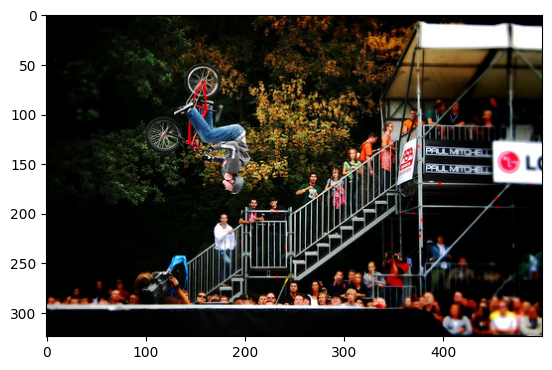

Model caption is: <SOS> a man is doing a trick on a bicycle . <EOS>
Label caption is: <SOS> biker performing jump while onlookers watch . <EOS>


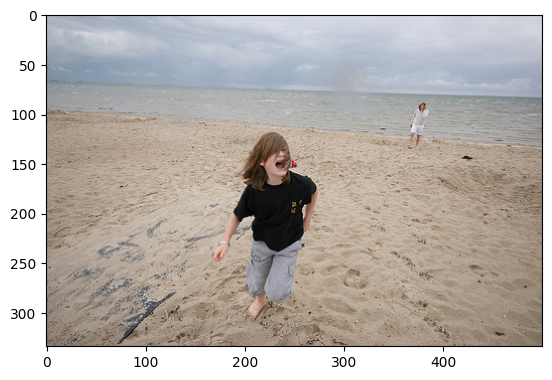

Model caption is: <SOS> a young girl is playing in the sand . <EOS>
Label caption is: <SOS> the girl is running on the sand near the beach . <EOS>


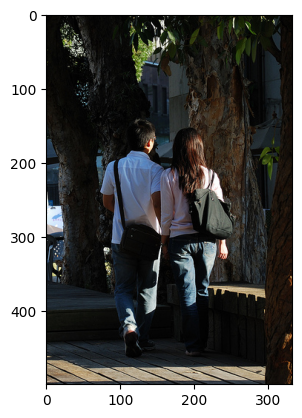

Model caption is: <SOS> a man and a woman are standing on a park bench . <EOS>
Label caption is: <SOS> a man and a woman walk in across a courtyard with black <UNK> bags on their shoulders . <EOS>


In [38]:
Sample_Caption(model=final_model, dataset= test_ds, vocab=test_ds.dataset.vocab, num_samples=3)